In [ ]:
img = Image.open(img_path)
mask = Image.open(mask_path)


In [ ]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# 1. Montar Drive
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 2. Rutas EXACTAS que tú diste
# -----------------------------
BASE = Path('/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/coffee_leaves/train')
IMGS_DIR = BASE / 'imgs'
MASKS_DIR = BASE / 'masks'

# -----------------------------
# 3. Listar archivos
# -----------------------------
img_files = sorted([f for f in IMGS_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']])
mask_files = sorted([f for f in MASKS_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']])

print("Imágenes encontradas:", len(img_files))
print("Máscaras encontradas:", len(mask_files))

# -----------------------------
# 4. Cargar una imagen y su máscara tal cual
# -----------------------------
img_path = img_files[0]
mask_path = mask_files[0]

img = Image.open(img_path)          # SIN convertir formato
mask = Image.open(mask_path)        # SIN convertir formato

# -----------------------------
# 5. Mostrar sin convertir nada
# -----------------------------
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Imagen")
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Máscara")
plt.imshow(mask)
plt.axis('off')

plt.show()



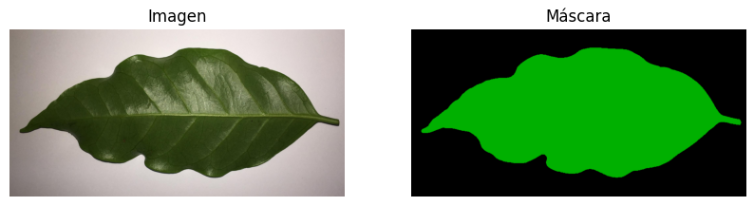

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

N = 5  # preview de datos cargados

for i in range(N):

    # ---- cargar imagen y máscara ----
    img = Image.open(img_files[i]).convert("RGB")
    mask = Image.open(mask_files[i]).convert("RGB")

    img_np = np.array(img)
    mask_np = np.array(mask)

    # ---- Segmentación A: Hoja (0,176,0) ----
    leaf_mask = (
        (mask_np[:,:,0] == 0) &
        (mask_np[:,:,1] == 176) &
        (mask_np[:,:,2] == 0)
    ).astype(np.uint8)

    # ---- Segmentación B: Enfermedad (255,0,0) ----
    disease_mask = (
        (mask_np[:,:,0] == 255) &
        (mask_np[:,:,1] == 0) &
        (mask_np[:,:,2] == 0)
    ).astype(np.uint8)

    # ---- Visualización ----
    plt.figure(figsize=(18,5))

    plt.subplot(1,4,1)
    plt.title(f"Imagen\n{img_files[i].name}")
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.title("Máscara original")
    plt.imshow(mask_np)
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.title("Seg. A (Hoja)\nverde 0,176,0")
    plt.imshow(leaf_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.title("Seg. B (Padecimiento)\nrojo 255,0,0")
    plt.imshow(disease_mask, cmap='gray')
    plt.axis('off')

    plt.show()

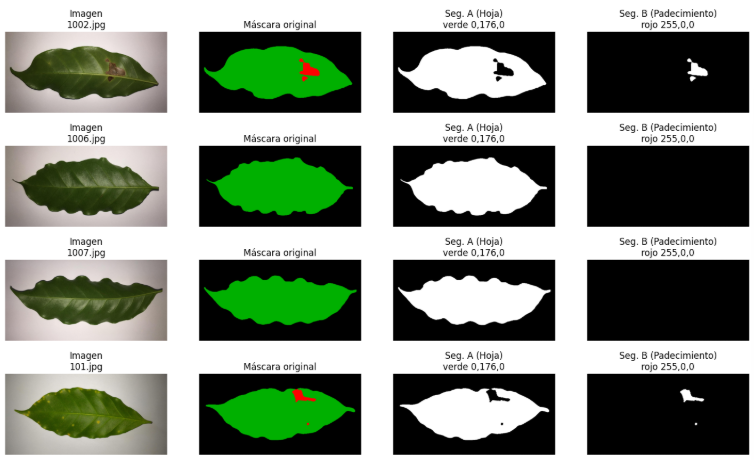

In [ ]:
# ResUNet multi-output (2 canales) - ENTRENAMIENTO usando 2 máscaras binarias (Hoja, Padecimiento)
# Pegar entero en Colab. Ajusta IMG_SIZE, BATCH_SIZE, EPOCHS según memoria.

import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K


In [ ]:
# Montar Drive (si no montado)
from google.colab import drive
drive.mount('/content/drive')

# -------------------------
# 1) Rutas / parámetros
# -------------------------


BASE = Path('/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/coffee_leaves/train')
IMGS_DIR = BASE / 'imgs'
MASKS_DIR = BASE / 'masks'

IMG_SIZE = (256, 256)   # reduce si poca memoria
BATCH_SIZE = 4
LR = 2e-4
EPOCHS = 60
VALIDATION_SPLIT = 0.01#Antes 0.15
BASE_FILTERS = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Imgs dir:", IMGS_DIR)
print("Masks dir:", MASKS_DIR)


IMG_SIZE = (256, 256)

resolución a la que redimensionamos las imagenes y previamente a la entrada a la red.

si bien iniciamos con imagenes de 512x512, la idea de bajarlo surgio a partir el tiempo de entrenamiento en el momento del desarrollo del modelo, ya que se demoraba hasta 1 hora en training y no mejoraba sustancialmente los resultados

learning rate  = 1e-4 del optimizador este se va a utilizar para Adam en segmentación. Puedes ajustar con callbacks (ReduceLROnPlateau).

EPOCHS = 26
Ajusta según convergencia. Con pocos datos podrías necesitar más épocas, con muchos datos menos.

VALIDATION_SPLIT = 0.15

fracción del dataset reservada para validación (15%). Alternativa: usar un tf.data o sklearn.model_selection.train_test_split para control más fino, o particionar por carpetas.

BASE_FILTERS = 32

número de filtros en la primera capa convolucional (depth inicial). En UNet/ResUNet cada downsampling suele duplicar filtros: 32 → 64 → 128 → 256...

Mayor BASE_FILTERS → más parámetros y más memoria. Si tu GPU es limitada usa 16 u 32.

AUTOTUNE = tf.data.AUTOTUNE

usado con la API tf.data para que TensorFlow ajuste automáticamente el paralelismo de lectura / prefetch. Mejora rendimiento de input pipeline.

In [ ]:
# -------------------------
# 2) Emparejar rutas (solo una vez)
# -------------------------
def collect_pairs(imgs_dir: Path, masks_dir: Path):
    img_paths = sorted(list(imgs_dir.glob('*.*')))
    masks_map = {}
    for m in masks_dir.glob('*.*'):
        stem = m.stem
        if stem.endswith('_mask'):
            key = stem[:-5]
        else:
            key = stem
        masks_map[key] = m
    pairs = []
    for img in img_paths:
        key = img.stem
        mask = masks_map.get(key) or masks_map.get(key + '_mask')
        if mask:
            pairs.append((str(img), str(mask)))
        else:
            print("No mask for:", img.name)
    def nk(p):
        s = Path(p[0]).stem
        try: return int(s)
        except: return s
    pairs = sorted(pairs, key=nk)
    return pairs

pairs = collect_pairs(IMGS_DIR, MASKS_DIR)
img_paths = [p[0] for p in pairs]
mask_paths = [p[1] for p in pairs]
n = len(img_paths)
print("Pares encontrados:", n)
if n == 0:
    raise RuntimeError("No pairs found. Ajusta rutas.")

In [ ]:

# -------------------------
# 3) Función para convertir máscara original -> 2 canales binarios (sin re-cargar dataset)
#     Channel 0: HOJA (verde)
#     Channel 1: PADECIMIENTO (rojo)
#     Usamos tolerancia de color para ser robustos.
# -------------------------
def mask_to_two_channels_np(mask_path, img_size=IMG_SIZE):
    m = Image.open(mask_path).convert('RGB')
    m = m.resize(img_size, Image.NEAREST)
    arr = np.array(m, dtype=np.uint8)
    r = arr[:,:,0].astype(np.int32)
    g = arr[:,:,1].astype(np.int32)
    b = arr[:,:,2].astype(np.int32)

    # Detectar hoja: pixels verdosos
    # tolerancia: g alto, r y b bajos
    leaf = ((g > 100) & (r < 80) & (b < 80)).astype(np.uint8)

    # Detectar enfermedad: rojo dominante
    disease = ((r > 150) & (g < 100) & (b < 100)).astype(np.uint8)

    # Asegurar que no haya solapamiento: si hay solapamiento, priorizamos disease sobre leaf
    overlap = (leaf & disease).astype(np.uint8)
    if overlap.any():
        # remover overlap de leaf
        leaf = leaf & (1 - disease)

    two = np.stack([leaf, disease], axis=-1)  # shape (H,W,2)
    return two.astype(np.uint8)

# quick test on first mask (opcional)
# sample_two = mask_to_two_channels_np(mask_paths[0])
# print("Sample two channels shape:", sample_two.shape, "unique leaf:", np.unique(sample_two[...,0]), "disease unique:", np.unique(sample_two[...,1]))


In [ ]:
# -------------------------
# 4) loader numpy + tf.py_function wrapper (carga imagen una vez y crea máscaras en memoria)
# -------------------------
def load_image_and_two_masks_np(img_path, mask_path, img_size=IMG_SIZE):
    img = Image.open(img_path).convert('RGB').resize(img_size, Image.BILINEAR)
    img_arr = np.array(img).astype(np.float32) / 255.0
    mask_two = mask_to_two_channels_np(mask_path, img_size)
    mask_two = mask_two.astype(np.float32)  # valores 0/1 por canal
    return img_arr, mask_two

def tf_load(img_path, mask_path):
    img, mask = tf.py_function(
        func=lambda a,b: load_image_and_two_masks_np(a.numpy().decode('utf-8'), b.numpy().decode('utf-8'), IMG_SIZE),
        inp=[img_path, mask_path],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape((*IMG_SIZE, 3))
    mask.set_shape((*IMG_SIZE, 2))
    return img, mask

# -------------------------
# 5) split train/val y dataset (no doble lectura)
# -------------------------
idxs = np.arange(n)
np.random.seed(42)
np.random.shuffle(idxs)
n_val = max(1, int(VALIDATION_SPLIT * n))
val_idxs = idxs[:n_val]
train_idxs = idxs[n_val:]

train_img_paths = [img_paths[i] for i in train_idxs]
train_mask_paths = [mask_paths[i] for i in train_idxs]
val_img_paths = [img_paths[i] for i in val_idxs]
val_mask_paths = [mask_paths[i] for i in val_idxs]

def make_ds(img_list, mask_list, batch=BATCH_SIZE, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
    if augment:
        ds = ds.shuffle(len(img_list), reshuffle_each_iteration=True)
    ds = ds.map(tf_load, num_parallel_calls=AUTOTUNE)
    if augment:
        def aug(image, mask):
            # Same transform for image & mask
            k = tf.random.uniform([], 0, 4, dtype=tf.int32)
            image = tf.image.rot90(image, k); mask = tf.image.rot90(mask, k)
            image = tf.image.random_flip_left_right(image)
            mask = tf.image.random_flip_left_right(mask)
            image = tf.image.random_flip_up_down(image)
            mask = tf.image.random_flip_up_down(mask)
            # brightness only on image
            image = tf.image.random_brightness(image, 0.08)
            image = tf.image.random_contrast(image, 0.95, 1.05)
            return image, mask
        ds = ds.map(aug, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_img_paths, train_mask_paths, batch=BATCH_SIZE, augment=True)
val_ds = make_ds(val_img_paths, val_mask_paths, batch=BATCH_SIZE, augment=False)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

# -------------------------
# 6) ResUNet (salida 2 canales, sigmoid)
# -------------------------
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, padding='same', strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut]); x = layers.Activation('relu')(x)
    return x

def upsample_concat(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = residual_block(x, filters)
    return x

def build_resunet(input_shape=(*IMG_SIZE,3), out_channels=2, filters=BASE_FILTERS):
    inputs = layers.Input(input_shape)
    c1 = residual_block(inputs, filters); p1 = layers.MaxPooling2D()(c1)
    c2 = residual_block(p1, filters*2); p2 = layers.MaxPooling2D()(c2)
    c3 = residual_block(p2, filters*4); p3 = layers.MaxPooling2D()(c3)
    c4 = residual_block(p3, filters*8); p4 = layers.MaxPooling2D()(c4)
    bn = residual_block(p4, filters*16)
    u1 = upsample_concat(bn, c4, filters*8)
    u2 = upsample_concat(u1, c3, filters*4)
    u3 = upsample_concat(u2, c2, filters*2)
    u4 = upsample_concat(u3, c1, filters)
    outputs = layers.Conv2D(out_channels, 1, activation='sigmoid')(u4)
    return models.Model(inputs, outputs, name='ResUNet_multi')

model = build_resunet()
model.summary()


Train batches: 99 Val batches: 1
Model: "ResUNet_multi"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    590,080 │ activation_6[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     33,024 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ activation_8[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │    131,584 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 16, 16,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ activation_9[0][… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ activation_10[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │    131,328 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 32, 32,    │          0 │ add_5[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ activation_11[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     32,896 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │     32,832 │ activation_13[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      8,256 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 128, 128,  │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 256, 256,  │      8,224 │ activation_15[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │     18,464 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_16[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      2,080 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 256, 256,  │          0 │ add_8[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │         66 │ activation_17[0]… │
│                     │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
 Total params: 8,127,522 (31.00 MB)
 Trainable params: 8,118,690 (30.97 MB)
 Non-trainable params: 8,832 (34.50 KB)

In [ ]:

# -------------------------
# 7) Loss y métricas (BCE + Dice por canal)
# -------------------------
def dice_coef_channel(y_true, y_pred, smooth=1e-6):
    # expects [B,H,W,C] where C == 2
    axes = (1,2)
    inter = K.sum(y_true * y_pred, axis=axes)
    sums = K.sum(y_true + y_pred, axis=axes)
    dice = (2. * inter + smooth) / (sums + smooth)
    return K.mean(dice, axis=-1)  # mean over channels

def dice_loss_channel(y_true, y_pred):
    return 1.0 - dice_coef_channel(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss_channel(y_true, y_pred)
    return bce + dl

# metrics: dice per channel
def mean_dice_metric(y_true, y_pred):
    return tf.reduce_mean(dice_coef_channel(y_true, y_pred))

def iou_metric_approx(y_true, y_pred, thresh=0.5):
    y_pred_bin = tf.cast(y_pred > thresh, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred_bin, axis=[1,2]) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return tf.reduce_mean(iou)

model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss=bce_dice_loss,
              metrics=[mean_dice_metric, iou_metric_approx])

# -------------------------
# 8) Callbacks y fit
# -------------------------
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/resunet2ch_best.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

steps_per_epoch = max(1, len(train_img_paths) // BATCH_SIZE)
validation_steps = max(1, len(val_img_paths) // BATCH_SIZE)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

model.save('/content/resunet2ch_final.h5')
print("Modelo guardado en /content/resunet2ch_final.h5")


In [ ]:

# -------------------------
# 9) Curvas de entrenamiento
# -------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['mean_dice_metric'], label='train mean dice')
plt.plot(history.history.get('val_mean_dice_metric',[]), label='val mean dice')
plt.legend(); plt.title('Mean Dice')

plt.show()


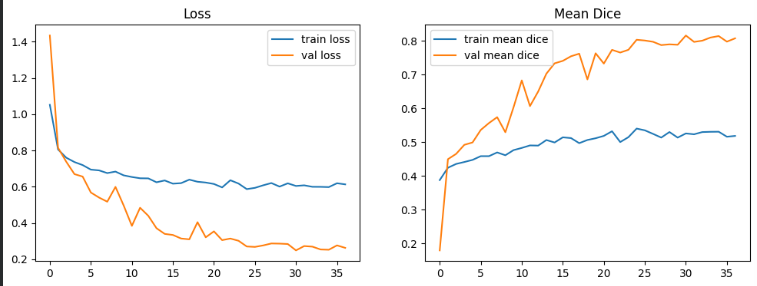

In [ ]:

# -------------------------
# 10) Evaluación simple sobre val set (recolectar predicciones)
# -------------------------
def compute_metrics_np(all_t, all_p, eps=1e-7):
    # all_t shape (N,H,W,2) binary ints, all_p probs -> binarize at 0.5
    p_bin = (all_p > 0.5).astype(np.uint8)
    dices = []
    ious = []
    for c in range(all_t.shape[-1]):
        t = all_t[...,c].astype(np.uint8)
        p = p_bin[...,c].astype(np.uint8)
        inter = (t & p).sum(axis=(1,2))
        denom = t.sum(axis=(1,2)) + p.sum(axis=(1,2))
        dice_per_sample = (2*inter + eps) / (denom + eps)
        iou_per_sample = (inter + eps) / (t.sum(axis=(1,2)) + p.sum(axis=(1,2)) - inter + eps)
        dices.append(np.mean(dice_per_sample))
        ious.append(np.mean(iou_per_sample))
    return dices, ious

# colectar predicciones de val set (al menos validation_steps batches)
val_it = iter(val_ds)
all_t = []; all_p = []
for _ in range(validation_steps):
    try:
        imgs_b, masks_b = next(val_it)
    except StopIteration:
        break
    imgs_np = imgs_b.numpy()
    masks_np = masks_b.numpy()
    preds = model.predict(imgs_np)
    all_t.append(masks_np)
    all_p.append(preds)
if len(all_t) > 0:
    all_t = np.concatenate(all_t, axis=0)
    all_p = np.concatenate(all_p, axis=0)
    dices, ious = compute_metrics_np(all_t, all_p)
    for c, name in enumerate(['Hoja', 'Padecimiento']):
        print(f"Clase {name}: Dice={dices[c]:.4f}, IoU={ious[c]:.4f}")
else:
    print("No hubo datos de validación para evaluar.")


In [ ]:

# -------------------------
# 11) Visualizar predicciones (comparar Image, Mask original, GT channels, Pred channels)
# -------------------------
def visualize_predictions(model, val_ds, n=4):
    it = iter(val_ds)
    imgs, masks = next(it)  # [B,H,W,3], [B,H,W,2]
    imgs_np = imgs.numpy()
    masks_np = masks.numpy()
    preds = model.predict(imgs_np)
    preds_bin = (preds > 0.5).astype(np.uint8)

    for i in range(min(n, imgs_np.shape[0])):
        fig, axs = plt.subplots(1,6, figsize=(20,4))

        axs[0].imshow(imgs_np[i])
        axs[0].set_title('Image')
        axs[0].axis('off')

        axs[1].imshow(np.clip(masks_np[i].sum(-1), 0, 1), cmap='gray')
        axs[1].set_title('Mask (sum)')
        axs[1].axis('off')

        # --- AQUÍ estaba el error: corregido ---
        axs[2].imshow(masks_np[i, ..., 0], cmap='gray')
        axs[2].set_title('GT Hoja')
        axs[2].axis('off')

        axs[3].imshow(masks_np[i, ..., 1], cmap='gray')
        axs[3].set_title('GT Padecimiento')
        axs[3].axis('off')

        axs[4].imshow(preds[i, ..., 0], cmap='gray')
        axs[4].set_title('Pred Hoja (prob)')
        axs[4].axis('off')

        axs[5].imshow(preds[i, ..., 1], cmap='gray')
        axs[5].set_title('Pred Padecimiento (prob)')
        axs[5].axis('off')

        plt.show()

visualize_predictions(model, val_ds, n=4)


https://chatgpt.com/share/692253f5-9a50-800f-9495-d7213f3fe36f



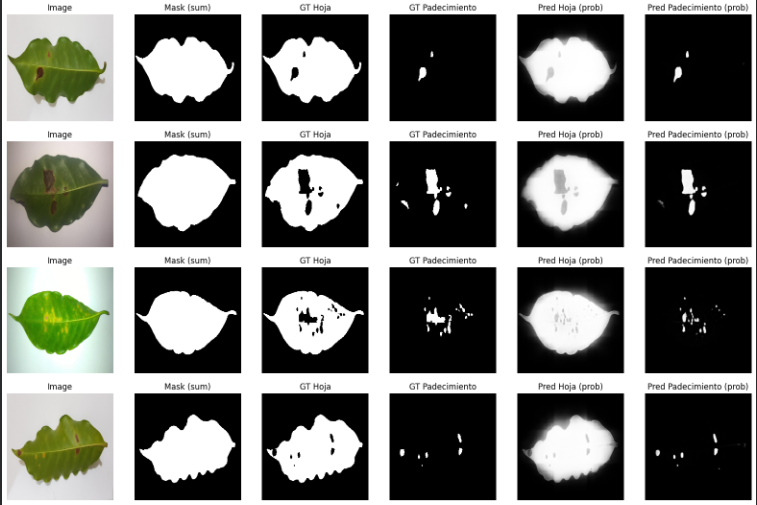

In [ ]:
# Ruta donde quieres guardar el modelo
MODEL_PATH = "/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/resunet2ch_final.keras"

model.save(MODEL_PATH)
print("Modelo guardado en:", MODEL_PATH)


In [ ]:
from tensorflow import keras

MODEL_PATH = "/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/resunet2ch_final.keras"

model = keras.models.load_model(
    MODEL_PATH,
    compile=False  # No compila porque no necesitamos entrenar
)

print("Modelo cargado correctamente.")


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

# -----------------------------
# 1. Cargar modelo
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/resunet2ch_final.keras"
model = keras.models.load_model(MODEL_PATH, compile=False)
print("Modelo cargado correctamente.")

# -----------------------------
# 2. Rutas del TEST SET
# -----------------------------
TEST_BASE = Path('/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/coffee_leaves/test')
IMGS_DIR = TEST_BASE / 'imgs'
MASKS_DIR = TEST_BASE / 'masks'

img_files = sorted([f for f in IMGS_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']])
mask_files = sorted([f for f in MASKS_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']])

print("Imágenes de TEST encontradas:", len(img_files))
print("Máscaras de TEST encontradas:", len(mask_files))

# -----------------------------
# 3. Funciones de carga
# -----------------------------
IMG_SIZE = (256, 256)

def load_img(path):
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    return np.array(img) / 255.0

def load_mask(path):
    mask = Image.open(path).convert("RGB").resize(IMG_SIZE)
    return np.array(mask) / 255.0

# -----------------------------
# 4. Loop de predicciones
# -----------------------------
for img_path, mask_path in zip(img_files, mask_files):

    img = load_img(img_path)
    mask = load_mask(mask_path)

    pred = model.predict(np.expand_dims(img, axis=0))[0]

    seg_leaf = pred[..., 0]       # Canal hoja
    seg_disease = pred[..., 1]    # Canal enfermedad

    # -----------------------------
    # Mostrar resultados
    # -----------------------------
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(img)
    axs[0].set_title("Imagen Original")
    axs[0].axis('off')

    axs[1].imshow(mask)
    axs[1].set_title("Máscara Original")
    axs[1].axis('off')

    axs[2].imshow(seg_leaf, cmap="gray")
    axs[2].set_title("Predicción Hoja (Canal 0)")
    axs[2].axis('off')

    axs[3].imshow(seg_disease, cmap="gray")
    axs[3].set_title("Predicción Enfermedad (Canal 1)")
    axs[3].axis('off')

    plt.show()


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

# -----------------------------
# 1. Cargar modelo
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/resunet2ch_final.keras"
model = keras.models.load_model(MODEL_PATH, compile=False)
print("Modelo cargado correctamente.")

# -----------------------------
# 2. Rutas del TEST SET
# -----------------------------
TEST_BASE = Path('/content/drive/MyDrive/Inteligencia Artificial/Practica/U-Net Coffee/coffee_leaves/test')
IMGS_DIR = TEST_BASE / 'imgs'
MASKS_DIR = TEST_BASE / 'masks'

img_files = sorted([f for f in IMGS_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']])
mask_files = sorted([f for f in MASKS_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']])

print("Imágenes de TEST encontradas:", len(img_files))
print("Máscaras de TEST encontradas:", len(mask_files))

# -----------------------------
# 3. Funciones de carga
# -----------------------------
IMG_SIZE = (256, 256)

def load_img(path):
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    return np.array(img) / 255.0

def load_mask(path):
    mask = Image.open(path).convert("RGB").resize(IMG_SIZE)
    return np.array(mask) / 255.0

# -----------------------------
# 4. Funciones para colorear predicciones
# -----------------------------
def colorize_prediction(pred_leaf, pred_disease, threshold=0.5):
    """
    pred_leaf: canal hoja (0–1)
    pred_disease: canal enfermedad (0–1)
    """

    leaf_bin = (pred_leaf > threshold).astype(np.uint8)
    disease_bin = (pred_disease > threshold).astype(np.uint8)

    # Verde para hoja (0,255,0)
    leaf_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    leaf_rgb[..., 1] = leaf_bin * 255

    # Rojo para enfermedad (255,0,0)
    disease_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    disease_rgb[..., 0] = disease_bin * 255

    # Combinado
    combined = leaf_rgb + disease_rgb

    return leaf_rgb, disease_rgb, combined

# -----------------------------
# 5. Loop de predicciones
# -----------------------------
for img_path, mask_path in zip(img_files, mask_files):

    img = load_img(img_path)
    mask = load_mask(mask_path)

    pred = model.predict(np.expand_dims(img, axis=0))[0]

    seg_leaf = pred[..., 0]
    seg_disease = pred[..., 1]

    # Colorear predicciones
    pred_leaf_rgb, pred_disease_rgb, pred_combined = colorize_prediction(seg_leaf, seg_disease)

    # -----------------------------
    # Mostrar resultados
    # -----------------------------
    fig, axs = plt.subplots(1, 5, figsize=(25, 6))

    axs[0].imshow(img)
    axs[0].set_title("Imagen Original")
    axs[0].axis('off')

    axs[1].imshow(mask)
    axs[1].set_title("Máscara GT")
    axs[1].axis('off')

    axs[2].imshow(pred_leaf_rgb)
    axs[2].set_title("Predicción Hoja (verde)")
    axs[2].axis('off')

    axs[3].imshow(pred_disease_rgb)
    axs[3].set_title("Predicción Enfermedad (rojo)")
    axs[3].axis('off')

    axs[4].imshow(pred_combined)
    axs[4].set_title("Predicción Combinada")
    axs[4].axis('off')

    plt.show()


La idea con este modelo es la implementacion de una UNet que son utiles en el analisis de imagen y poder entrenar un modelo capaz de reconocer las hojas de cafe y algun padecimiento o daño que estas tengan.

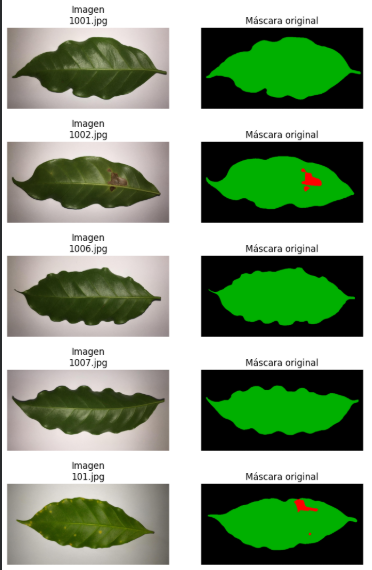

Tenemos un conjunto de 500 imagenes con sus respectivas mascaras 
el primer inconveniente con el que me encontre es que el reconocimiento de caracteristicas.Existen 3 criterios el fondo,la hoja y mancha, estos ultimos 2 estan bien definidos dentro de las mascaras respectivas, el problemas es que el modelo era solo capaz de definir la hoja, no entendia la parte de las manchas o padecimientos.

para ello intente una solucion, el objetivo es utilizar segmentacion binaria 2 veces con el fin de definir 2 segmentaciones en vez de una, una con la hoja y la otra con la mancha o padecimiento de la hoja.

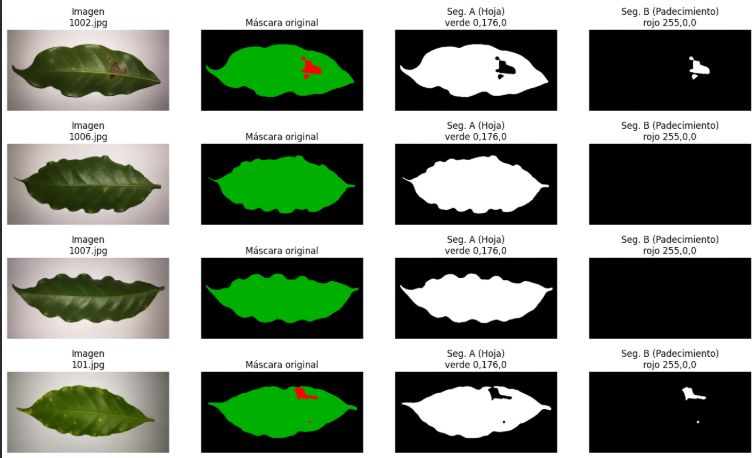

Con esto nos quedamos con un modelo que se entrena con 3 entradas en vez de 2, y que recibiria 1 entrada y daria 2 salidas 

U-Net:

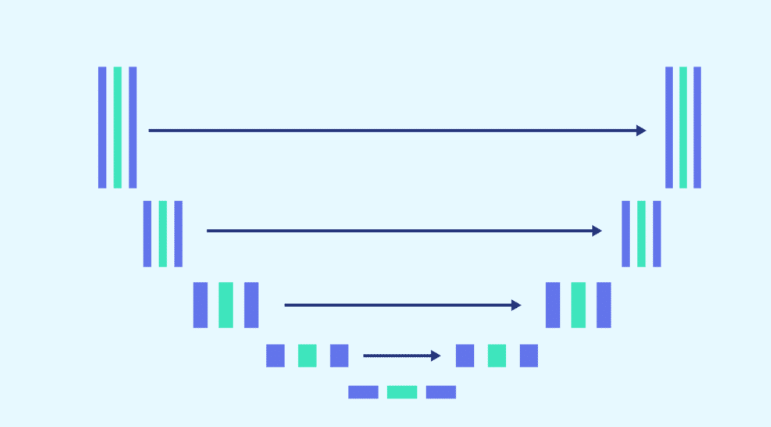

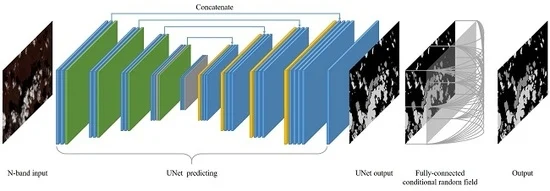

U-Net es una red neuronal convolucional desarrollada para la segmentación de imágenes biomédicas en el Departamento de Informática de la Universidad de Friburgo.[1]​ La red se basa en una red neuronal totalmente convolucional[2]​ cuya arquitectura se modificó y amplió para trabajar con menos imágenes de entrenamiento y producir una segmentación más precisa. La segmentación de una imagen de 512 × 512 tarda menos de un segundo en una GPU moderna.

La arquitectura U-Net también se ha empleado en modelos de difusión para la eliminación iterativa de ruido en imágenes.[3]​ Esta tecnología es la base de muchos modelos modernos de generación de imágenes, como DALL-E, Midjourney y Stable Diffusion.

Lo que obtuvimos con ello es un modelo con una perdida de 0.57 como minimo lo cual puede ser un poco alto pero se trata de un resultado destacable, el modelo se entreno en varias ocasiones entre 25  y 60 epocas siendo 32 el de mejor resultado, con un learning rate de 0.1e^-4 adaptativo. ya que al llegar a 0.57 se estanca y el modelo se vuelve incapaz de mejorar su prediccion 

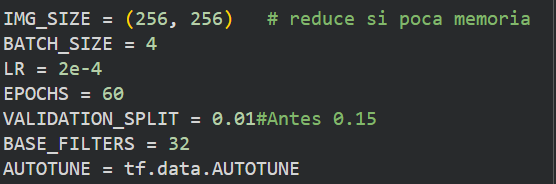


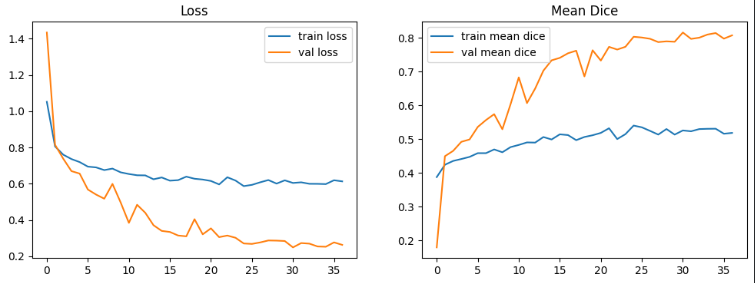


lo que estoy considerando es en principio campbiar a Adam como algoritmo de optimizacion, aumentar el tamaño de la imagen, reducir las epocas y el batch size, para tratar de que la perdida sea inferior a 0.20, no obstante los resultados me parecen destacablemente buenos.

y creo que en un caso muy extemo hacer una ultima segmentacion eliminando o diferenciando aun mas el fondo de la imagen


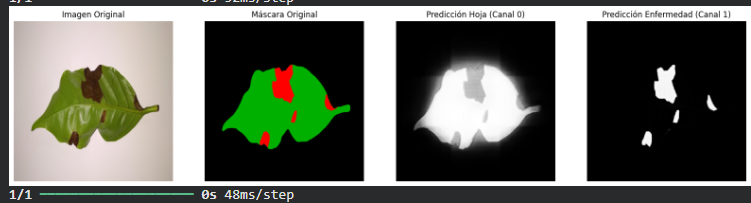
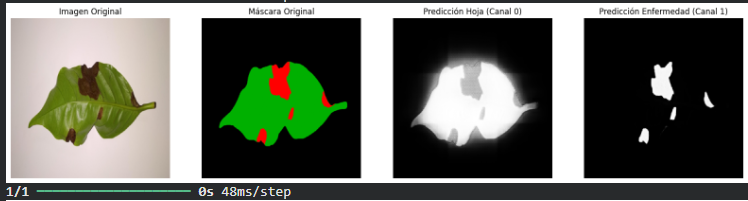
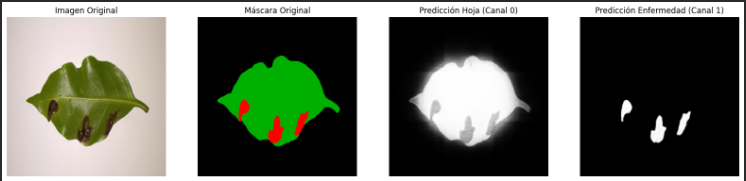
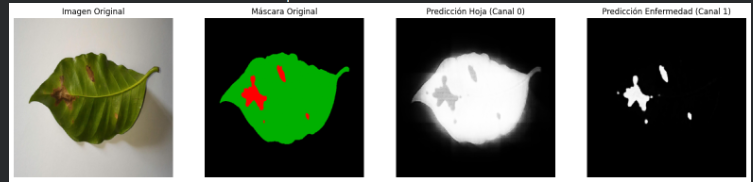
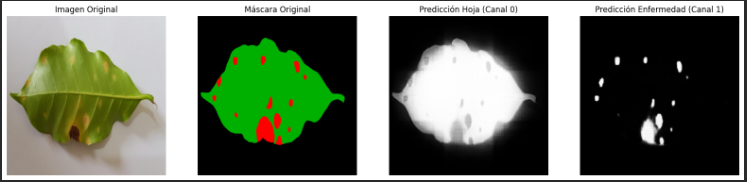

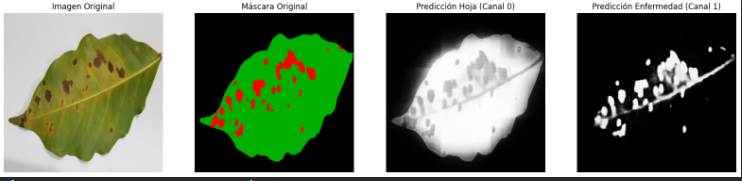
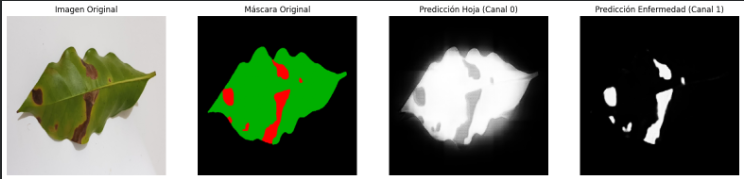
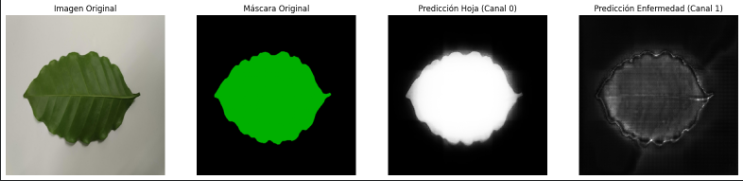

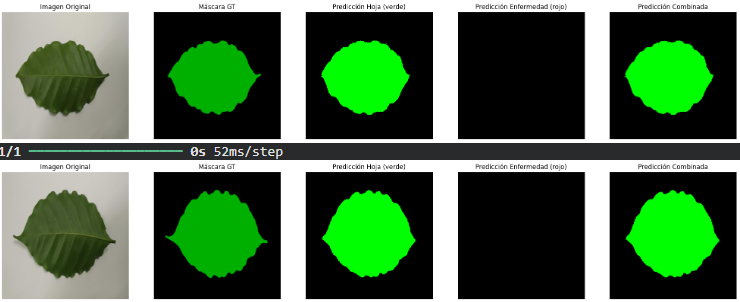
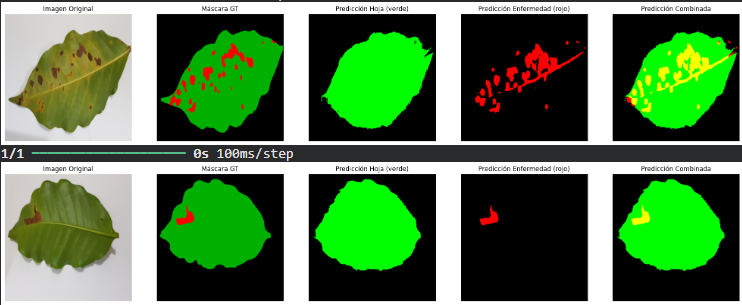
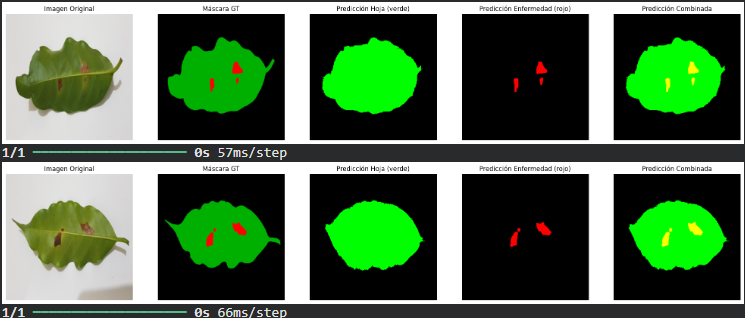
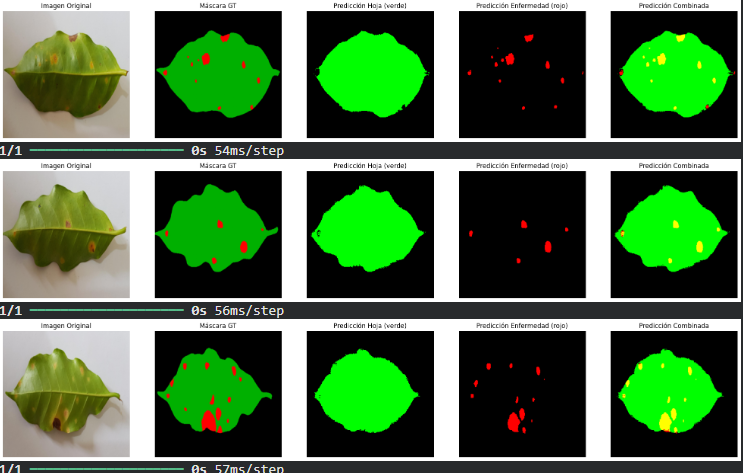

PD: Antes de terminar este modelo me arriesgue a aumentar un tanto las cualidades del modelo para ver si era capaz de reconocer de mejor manera lo solicitado, a simple vista los resultados de aprendizaje mejoraron significativamente sobretodo al realizarlo con un tamaño de imagen de 512x512

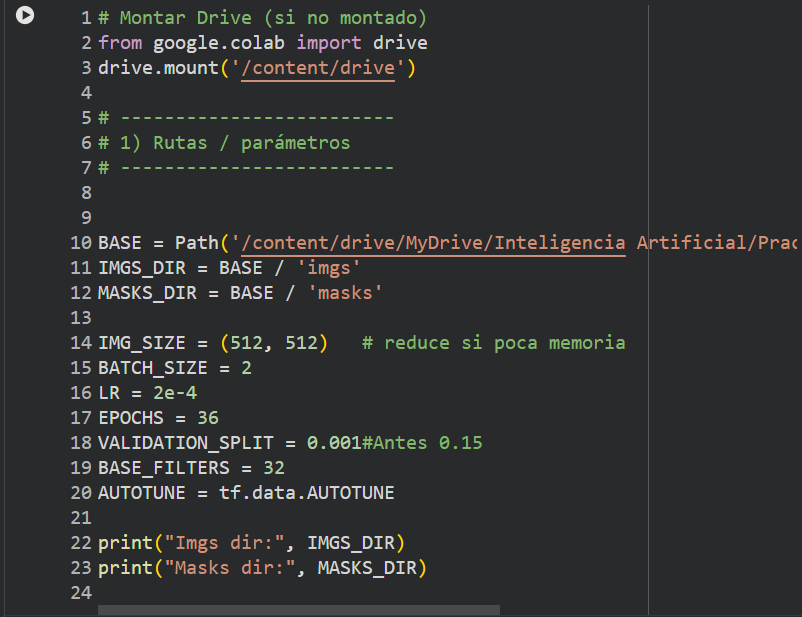

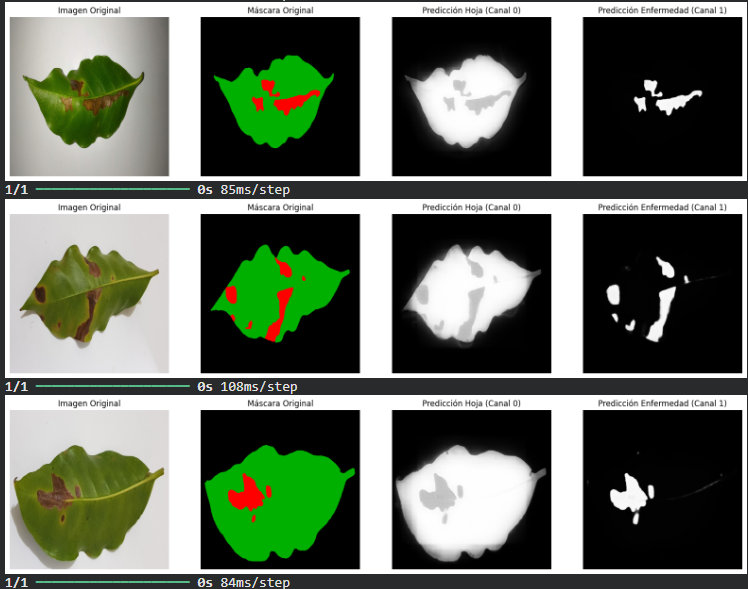